# Indiana Groundwater Chemistry

All of Indiana is above the Wabash basin, a subbasin of the Missippi river. This notebook looks at a historical groundwater chemistry dataset. Published by the Indiana DNR.

In [39]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import utm
import shapefile


In [40]:
#import data

#set the filepath
gw_filepath = r"C:\Users\janel\OneDrive\Documents\IU grad\Classes F23\EAS 690 Advanced Data Science\G690_Test\research_project\IDNR_GWchem\Data\GWCHEM_AA.xls"

# read in the data file
# dates are listed in seperate columns: 30, 31, 32 for month, day, year
IDNR_gw_full = pd.read_excel(gw_filepath, 
                             sheet_name = "basins", 
                             header = 6, 
                             skiprows = 6,
                             #index_col='date', 
                             parse_dates={'date': [32,30,31]})

# show the top of the dataset
IDNR_gw_full.head()

,date,ref.no,pub.no,samp.no,UTMN,UTME,COUNTY,TOWNSHIP,RANGE,SECTION,...,LEAD,ARS,SEL,BOR,COMMENTS.1,Well type,Ref No.,Unnamed: 59,Sample #,Basin
0,1989-07-19,85,NaN,WF-024,4451775,623650,18,20,9,6,...,NaN,NaN,NaN,NaN,NaN,B,85,NaN,WF-024,WF
1,1989-07-11,1302,NaN,WF-002,4450598,632343,18,20,10,7,...,NaN,NaN,NaN,NaN,NaN,U,1302,NaN,WF-002,WF
2,1989-07-11,1551,NaN,WF-003,4447960,637860,18,20,10,22,...,NaN,NaN,NaN,NaN,NaN,U,1551,NaN,WF-003,WF
3,1989-07-13,2577,NaN,WF-014,4456595,627750,18,21,9,22,...,NaN,NaN,NaN,NaN,NaN,B,2577,NaN,WF-014,WF
4,1989-07-13,2752,NaN,WF-011A,4459750,641860,18,21,10,12,...,NaN,NaN,NaN,NaN,NaN,B,2752,NaN,WF-011A,WF


In [41]:
#convert UTM coordinates to lat lon
IDNR_gw_full['lat'], IDNR_gw_full['lon'] = utm.to_latlon(IDNR_gw_full['UTME'], IDNR_gw_full['UTMN'], 16, northern=True)
IDNR_gw_full.head()

,date,ref.no,pub.no,samp.no,UTMN,UTME,COUNTY,TOWNSHIP,RANGE,SECTION,...,SEL,BOR,COMMENTS.1,Well type,Ref No.,Unnamed: 59,Sample #,Basin,lat,lon
0,1989-07-19,85,NaN,WF-024,4451775,623650,18,20,9,6,...,NaN,NaN,NaN,B,85,NaN,WF-024,WF,40.207272,-85.547048
1,1989-07-11,1302,NaN,WF-002,4450598,632343,18,20,10,7,...,NaN,NaN,NaN,U,1302,NaN,WF-002,WF,40.195345,-85.445177
2,1989-07-11,1551,NaN,WF-003,4447960,637860,18,20,10,22,...,NaN,NaN,NaN,U,1551,NaN,WF-003,WF,40.170698,-85.380950
3,1989-07-13,2577,NaN,WF-014,4456595,627750,18,21,9,22,...,NaN,NaN,NaN,B,2577,NaN,WF-014,WF,40.250068,-85.497927
4,1989-07-13,2752,NaN,WF-011A,4459750,641860,18,21,10,12,...,NaN,NaN,NaN,B,2752,NaN,WF-011A,WF,40.276208,-85.331388


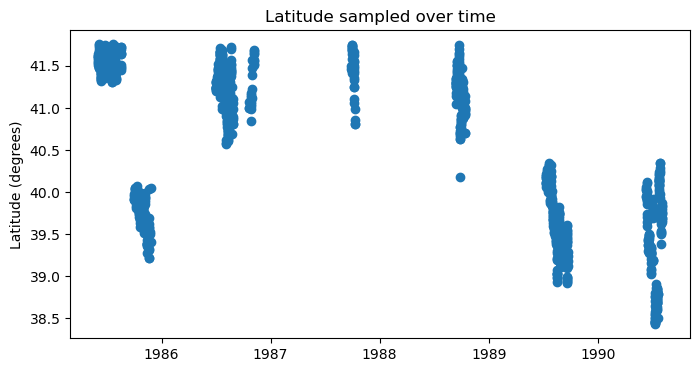

In [46]:
#display data entries over time

""" Create dates and plot the data. """
#gw_dates = pd.date_range(start='1985-01-01', end='1991-12-31', freq='d')

#plot the data over time
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(IDNR_gw_full['date'], IDNR_gw_full['lat'])
ax.set_title("Latitude sampled over time")
ax.set_ylabel("Latitude (degrees)")
plt.show()

Interesting spread of data over time... There's a suspicious lack of data in the middle latitudes. Let's see what the data looks like on a map.

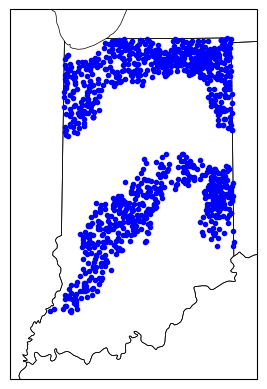

In [69]:
#display data points on map

#set projection, transformation, and center
bloomington_lon = -86.526386
bloomington_lat = 39.165325
projection = cartopy.crs.Orthographic(central_longitude=bloomington_lon, central_latitude=bloomington_lat)
transform = cartopy.crs.PlateCarree()

#create the plot
fig, ax = plt.subplots( subplot_kw= dict(projection = projection))
ax.plot(IDNR_gw_full['lon'], IDNR_gw_full['lat'], '.', color="b", transform = transform)
#add states outline
ax.add_feature(cartopy.feature.STATES, linewidth=0.5)
# Set map extent
ax.set_extent([-88.3, -84.5, 37.6, 42.1], crs=cartopy.crs.PlateCarree())
plt.show()                  

The coverage here is not great, and not what I expected. But let's see how it aligns with the Wabash Basin.

Wabash HUC12 Subbasin Shapefile credits:
Dierauer, J.R. (2019). Wabash River Basin USGS NHD HUC 12 polygon shapefile. figshare. Dataset. https://doi.org/10.6084/m9.figshare.8398394.v7

In [60]:
# provide path of shapefile
shp_path = r'C:\Users\janel\OneDrive\Documents\IU grad\Classes F23\EAS 690 Advanced Data Science\G690_Test\research_project\data\WBHUC12shp\Wabash_HUC12.shp'

HUC_shp = shapefile.Reader(shp_path)

#print what shapetype the shapefile is. 5 means polygon
print(HUC_shp.shapeType)
#how many features are there?
len(HUC_shp)


5


1276

Our shapefile is set of 1276 polygons. A review of the file "WabashSubbasins_IDtoHUC.csv" (in data\WBHUC12shp) tells us there is indeed 1276 HUC12 subbasins in the basin, so we're likely looking at the right thing.

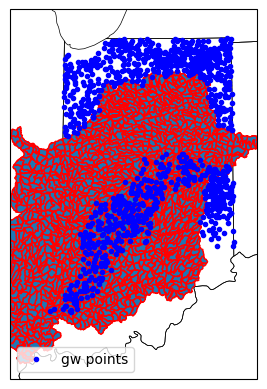

In [71]:
#import more specific functions
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader

#create the plot
fig, ax = plt.subplots( subplot_kw= dict(projection = projection))
ax.plot(IDNR_gw_full['lon'], IDNR_gw_full['lat'], '.', color="b", transform = transform, label = "gw points")
ax.add_feature(cartopy.feature.STATES, linewidth=0.5)
# Set map extent
ax.set_extent([-88.3, -84.5, 37.6, 42.1], crs=cartopy.crs.PlateCarree())



# add shapefile as feature
state_feature = ShapelyFeature(Reader(shp_path).geometries(),
                               crs=cartopy.crs.PlateCarree(), edgecolor='r')
ax.add_feature(state_feature)
ax.legend()



plt.show() 

This isn't pretty, but there's enough overlap for us to do an analysis with the overlapping sections.


It's interesting to see the groundwater sample points conform to the outline of the Wabash basin in parts, such as along the north border or part of the east. I wonder what's there that we can't see from this map.

In [45]:
#interpolate geochemical parameters
